In [1]:
import torch
from diffusers.models import AutoencoderKL
vae = AutoencoderKL.from_pretrained('timbrooks/instruct-pix2pix', subfolder='vae', torch_dtype=torch.float16).cuda()
# vae = AutoencoderKL.from_pretrained("ckpts/sdxl-vae", torch_dtype=torch.float16).cuda()
vae.requires_grad_(False)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [1]:
import numpy as np
from PIL import Image
import torchvision.transforms as T
def preprocess(images):
    if type(images) == list:
        images_pt = []
        for image in images:
            images_pt.append(T.ToTensor()(image) * 2 - 1)
        return torch.stack(images_pt)
    else:
        return T.ToTensor()(images).unsqueeze(0) * 2 - 1

def postprocess(latent_image, pil=True):
    latent_image = (latent_image + 1) / 2
    if pil:
        latent_image = latent_image[0].permute(1, 2, 0)
        return Image.fromarray((latent_image * 255).cpu().detach().numpy().astype(np.uint8))

In [2]:
image_pil = Image.open('data/nerf_llff_data/fern/images_4/IMG_4026.JPG')
image_np = np.array(image_pil)
image_pil.size

(1008, 752)

In [5]:
image_pt = preprocess([image_pil])
encode_out = vae.encode(image_pt.to(device=vae.device, dtype=vae.dtype))
latent_image = encode_out.latent_dist.mode()

In [6]:
latent_image.shape

torch.Size([1, 4, 105, 162])

In [13]:
import torch
from PIL import Image
import numpy as np
latent_images = torch.load('data/nerf_llff_data/fern/latents_4.pt')
latent_image = latent_images[2][None]

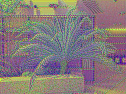

In [14]:
latent_image_norm = (latent_image - latent_image.min()) / (latent_image.max() - latent_image.min())
latent_image_pil = Image.fromarray((latent_image_norm[0].permute(1, 2, 0)[..., :3] * 255).cpu().detach().numpy().astype(np.uint8))
latent_image_pil

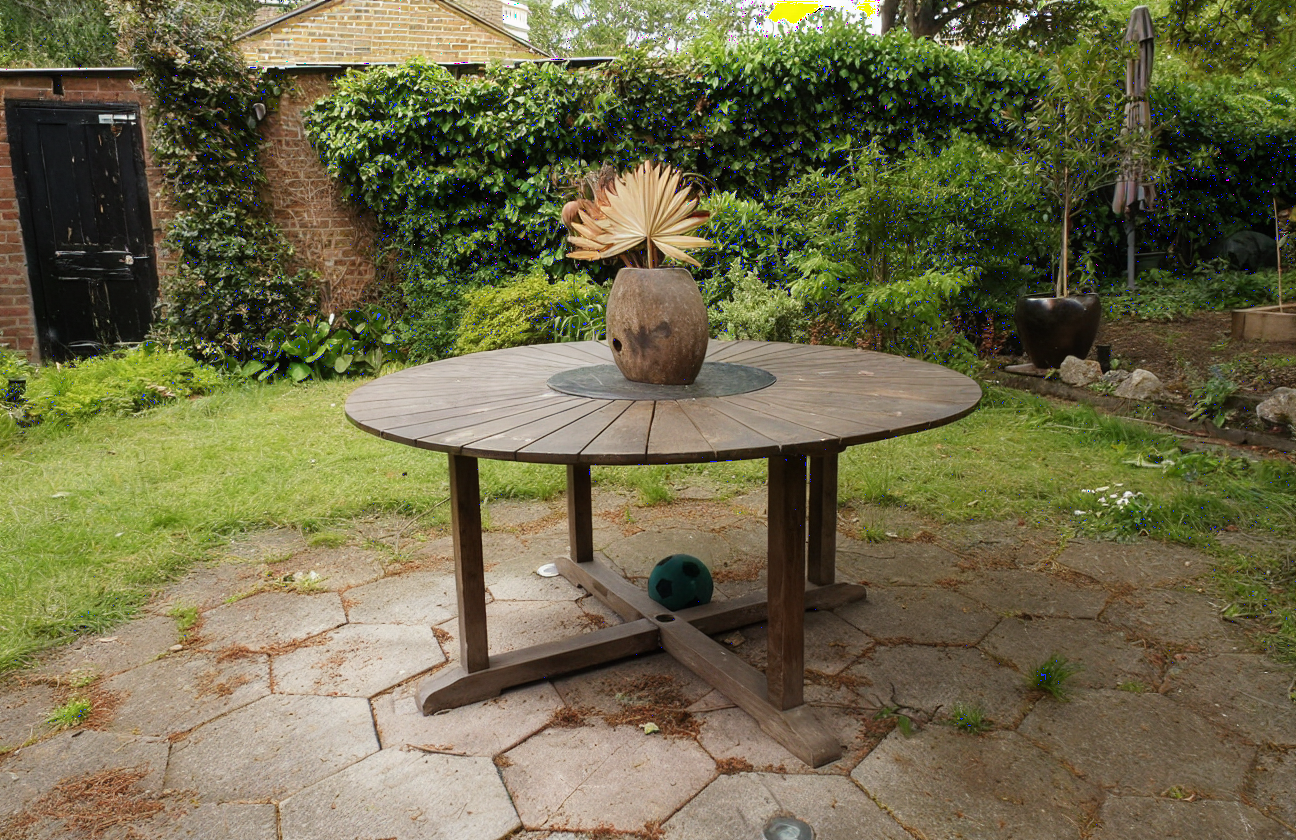

In [8]:
decode_out = vae.decode(latent_image, return_dict=False)[0]
re_img = postprocess(decode_out)
re_img

In [9]:
re_img.size

(1296, 840)